In [33]:
import numpy as np
import pandas as pd
from IPython.display import HTML
from pandarallel import pandarallel
pandarallel.initialize()

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [34]:
path_shared = '~/Downloads/nfl-big-data-bowl-2021/{}'

games_df = pd.read_csv(path_shared.format('games.csv'))
plays_df = pd.read_csv(path_shared.format('plays.csv'))
players_df = pd.read_csv(path_shared.format('players.csv'))
track_df = pd.read_csv(path_shared.format('week1_norm.csv'))

In [35]:
params = lambda: None # create an empty object to add params
params.a_max = 7
params.s_max = 9
params.reax_t = params.s_max/params.a_max
params.avg_ball_speed = 20
params.tti_sigma = 0.45
params.cell_length = 1
vars(params)


{'a_max': 7,
 's_max': 9,
 'reax_t': 1.2857142857142858,
 'avg_ball_speed': 20,
 'tti_sigma': 0.45,
 'cell_length': 1}

In [36]:
# game_id = 2018122314
# play_id = 4239
game_id = 2018090905
play_id = 2062
# game_id, play_id = random.choice(plays)

play_df = track_df[(track_df.playId == play_id) & (track_df.gameId == game_id)].sort_values(by = 'frameId')
play_df.head()

gameId  playId  frameId event      nflId          displayName  \
317421  2018090905    2062        1  None   496735.0       Kareem Jackson   
317434  2018090905    2062        1  None        0.0             Football   
317433  2018090905    2062        1  None  2558094.0      Zach Cunningham   
317432  2018090905    2062        1  None  2552490.0  Benardrick McKinney   
317430  2018090905    2062        1  None  2552261.0        Kevin Johnson   

        jerseyNumber position      team team_pos teamAbbr route  \
317421          25.0       CB      away      DEF      HOU   NaN   
317434           NaN      NaN  football     FTBL     FTBL   NaN   
317433          41.0      ILB      away      DEF      HOU   NaN   
317432          55.0      ILB      away      DEF      HOU   NaN   
317430          30.0       CB      away      DEF      HOU   NaN   

                            time  los      x      y   dis       o     s  \
317421  2018-09-09T18:28:11.700Z   40  54.51  31.08  0.08  260.44  0.83   
317434  2018-09-09T18:28:11.700Z   40  40.18  29.52  0.00     NaN  0.00   
317433  2018-09-09T18:28:11.700Z   40  44.36  32.36  0.05  263.88  0.49   
317432  2018-09-09T18:28:11.700Z   40  41.88  23.53  0.10  220.61  0.95   
317430  2018-09-09T18:28:11.700Z   40  48.40  17.56  0.05  135.60  0.50   

         s_dir  s_dir_rad   v_x   v_y  v_theta  v_mag  a_old  a_x  a_y  \
317421  108.40       1.89  0.79 -0.26    -0.32   0.83   0.38  0.0  0.0   
317434     NaN        NaN  0.00  0.00     0.00   0.00   0.00  0.0  0.0   
317433  262.25       4.58 -0.49 -0.07     0.14   0.49   0.72  0.0  0.0   
317432  298.75       5.21 -0.83  0.46    -0.50   0.95   0.03  0.0  0.0   
317430   27.09       0.47  0.23  0.45     1.10   0.50   0.46  0.0  0.0   

        a_theta  a_mag  
317421      0.0    0.0  
317434      0.0    0.0  
317433      0.0    0.0  
317432      0.0    0.0  
317430      0.0    0.0

In [69]:
%%time
import time
from scipy.spatial import distance
from ipdb import launch_ipdb_on_exception 

def get_field_df(play_frame_group):
    frame_df = play_frame_group.loc[(play_df.nflId!=0)]
    ball_start = frame_df.loc[frame_df.position=='QB', ['x', 'y']].iloc[0].round(0)
    frame_df = frame_df.loc[frame_df.position!='QB']
    #print(frame_df.columns)
    current_frame = min(frame_df.frameId)
    pocket_width = 10

    x = np.linspace(0.5, 119.5, 120)
    y = np.linspace(-0.5, 53.5, 55)
    y[0] = -0.2
    field_locs = np.stack(np.meshgrid(x, y)).reshape(2, -1).T  # (F, 2)
    
    T = np.linspace(0.1, 4, 40)
    receivers_df = frame_df.loc[frame_df.team_pos == 'DEF',['x', 'y', 'v_x', 'v_y', 'v_theta', 'v_mag', 'los', 'a_x', 'a_y']]
    dist_from_ball_np = np.linalg.norm((receivers_df.x - ball_start[0],
                                                     receivers_df.y - ball_start[1]), axis=0)
    # find the spot the qb would aim at, leading the receiver in their current dir by the ball time
    rec_x_np = receivers_df.x.to_numpy()[:,None]
    rec_y_np = receivers_df.y.to_numpy()[:,None]
    rec_v_x_np = receivers_df.v_x.to_numpy()[:,None]
    rec_v_y_np = receivers_df.v_y.to_numpy()[:,None]
    rec_a_x_np = receivers_df.a_x.to_numpy()[:,None]
    rec_a_y_np = receivers_df.a_y.to_numpy()[:,None]
    rec_v_theta_np = receivers_df.v_theta.to_numpy()[:,None]
    rec_v_x_r = rec_a_x_np*params.reax_t+rec_v_x_np
    rec_v_y_r = rec_a_y_np*params.reax_t+rec_v_y_np
    rec_v_r_mag = np.linalg.norm(np.array([rec_v_x_r, rec_v_y_r]), axis=0)
    rec_v_r_theta = np.arctan(rec_v_y_r/rec_v_x_r)
    
    #target_x = rec_x_np+rec_v_x_np*t+0.5*rec_a_x_np*t**2  # (R, T)
    #target_y = rec_y_np+rec_v_y_np*t+0.5*rec_a_y_np*t**2  # (R, T)
    
    x_r = rec_x_np + rec_v_x_np*params.reax_t - 0.5*rec_a_x_np*params.reax_t**2 #(R, 1)
    y_r = rec_y_np + rec_v_y_np*params.reax_t - 0.5*rec_a_y_np*params.reax_t**2 #(R, 1)
    
    reaction_player_locs = np.hstack((x_r, y_r)) # (R,2)
    reaction_player_vels = np.hstack((rec_v_x_r, rec_v_y_r)) # (R,2)
    
    int_d_vec = field_locs[:, None, :] - reaction_player_locs #(F, R, 2)
    int_d_mag = np.linalg.norm(int_d_vec, axis=2) # F, R
    int_theta = np.arctan(int_d_vec[:,:,1]/int_d_vec[:,:,0]) #this could be a problem
    
    
    int_s0 = np.clip(np.sum(int_d_vec*reaction_player_vels, axis=2)/int_d_mag, -params.s_max, params.s_max) #F, R,  #taking norm between vectors int_d and player velocity
        
    t_lt_smax = (params.s_max-int_s0)/params.a_max  #F, J,
    d_lt_smax = t_lt_smax*((int_s0+params.s_max)/2) #F, J,
    d_at_smax = int_d_mag - d_lt_smax               #F, J,
    t_at_smax = d_at_smax/params.s_max              #F, J,
    t_tot = t_lt_smax+t_at_smax                     #F, J,

    a1 =  np.broadcast_to(t_lt_smax[:,:,None],(*t_lt_smax.shape, len(T))) # F, J, T THIS IS TIME SPENT LT SMAX
    a2 =  np.broadcast_to(T[None,None,:],(*t_lt_smax.shape, len(T))) # F, J, T
    
    time_lt_smax = np.where(a1 > a2, a2, a1) # F, J, T  THIS IS TIME LESS THAN MAX
    time_at_smax = a2 - time_lt_smax # F, J, T THIS IS TIME MORE THAN MAX
    
    
    d = time_at_smax * params.s_max + int_s0[:,:,None]*time_lt_smax + 0.5*params.a_max*np.square(time_lt_smax) # F, J, T
    ## d = Time at max speed * max speed + int_s0* time at lt_smax + 1/2 params.a_max (time at lt_smax * time at lt_smax) 
    #d = 
    v_proj = int_s0[:,:,None] + params.a_max*np.square(time_lt_smax) # F, J, T
    v_proj = np.where(v_proj > params.s_max, params.s_max, v_proj) # F, J, T
    x_proj = x_r + d* np.cos(int_theta[:,:,None]) # F, J, T
    y_proj = y_r + d* np.sin(int_theta[:,:,None]) # F, J, T
    
    
    projected_locations = np.stack((x_proj, y_proj), axis =3)  # F, J, T, 2
    
    distances_to_ball = projected_locations - field_locs[:,None,None,:] # F, J, T, 2
    distance_mags = np.linalg.norm(distances_to_ball, axis = 3) # F, J, T
    
    sorted_indices = np.argsort(distance_mags, axis = 1) # F, J, T

    distance_mags = np.take_along_axis(distance_mags,sorted_indices, axis = 1)
    x_proj_sorted = np.take_along_axis(x_proj,sorted_indices, axis = 1) # F, J, T
    y_proj_sorted = np.take_along_axis(y_proj,sorted_indices, axis = 1) # F, J, T
    v_proj_sorted = np.take_along_axis(v_proj,sorted_indices, axis = 1) # F, J, T
    
    just_top_5_distances = distance_mags[:,0:5,:].transpose((0,2,1)) #F, T, 5
    just_top_5_x_proj = x_proj_sorted[:,0:5,:].transpose((0,2,1)) #F, T, 5
    just_top_5_y_proj = y_proj_sorted[:,0:5,:].transpose((0,2,1))  #F, T, 5
    just_top_5_v_proj = v_proj_sorted[:,0:5,:].transpose((0,2,1))  #F, T, 5
    
    
    just_top_5_distances = np.reshape(just_top_5_distances, (just_top_5_distances.shape[0]*just_top_5_distances.shape[1],just_top_5_distances.shape[2]))
    just_top_5_x_proj  = np.reshape(just_top_5_x_proj, just_top_5_distances.shape)
    just_top_5_y_proj  = np.reshape(just_top_5_y_proj, just_top_5_distances.shape)
    just_top_5_v_proj  = np.reshape(just_top_5_v_proj, just_top_5_distances.shape)

    
    endpoints = np.repeat(field_locs, repeats = len(T), axis = 0) # FxT, 2
    times = np.repeat(T[None, :], repeats = len(field_locs), axis = 0)
    times_shaped = times.reshape((times.shape[0]*times.shape[1]))# FxT, 1

    field_df = pd.DataFrame({
        'pass_endpoint_x': endpoints[:,0],
        'pass_endpoint_y': endpoints[:,1],
        'frame_thrown' : current_frame,
        'time_of_flight' : times_shaped,
        '1-closest-defender-distance' : just_top_5_distances[:,0],
        '2-closest-defender-distance' : just_top_5_distances[:,1],
        '3-closest-defender-distance' : just_top_5_distances[:,2],
        '4-closest-defender-distance' : just_top_5_distances[:,3],
        '5-closest-defender-distance' : just_top_5_distances[:,4],
        '1-closest-defender-x' : just_top_5_x_proj[:,0],
        '2-closest-defender-x' : just_top_5_x_proj[:,1],
        '3-closest-defender-x' : just_top_5_x_proj[:,2],
        '4-closest-defender-x' : just_top_5_x_proj[:,3],
        '5-closest-defender-x' : just_top_5_x_proj[:,4],
        '1-closest-defender-y' : just_top_5_y_proj[:,0], 
        '2-closest-defender-y': just_top_5_y_proj[:,1], 
        '3-closest-defender-y': just_top_5_y_proj[:,2], 
        '4-closest-defender-y': just_top_5_y_proj[:,3], 
        '5-closest-defender-y': just_top_5_y_proj[:,4], 
        '1-closest-defender-speed' : just_top_5_v_proj[:,0],
        '2-closest-defender-speed': just_top_5_v_proj[:,1],
        '3-closest-defender-speed': just_top_5_v_proj[:,2],
        '4-closest-defender-speed': just_top_5_v_proj[:,3],
        '5-closest-defender-speed': just_top_5_v_proj[:,4], 
        "y" : endpoints[:,1]
        
     })
    
    return field_df

field_dfs = play_df.loc[play_df.frameId <= play_df.loc[play_df.event=='pass_forward'].frameId.iloc[0]].groupby(['gameId', 'playId', 'frameId']).parallel_apply(get_field_df)
field_dfs = field_dfs.reset_index(3, drop=True).reset_index()
field_dfs

CPU times: user 11.5 s, sys: 47.5 s, total: 59 s
Wall time: 1min 34s


In [57]:

display(field_dfs.reset_index())

index      gameId  playId  frameId  pass_endpoint_x  \
0                0  2018090905    2062        1              0.5   
1                1  2018090905    2062        1              0.5   
2                2  2018090905    2062        1              0.5   
3                3  2018090905    2062        1              0.5   
4                4  2018090905    2062        1              0.5   
5                5  2018090905    2062        1              0.5   
6                6  2018090905    2062        1              0.5   
7                7  2018090905    2062        1              0.5   
8                8  2018090905    2062        1              0.5   
9                9  2018090905    2062        1              0.5   
10              10  2018090905    2062        1              0.5   
11              11  2018090905    2062        1              0.5   
12              12  2018090905    2062        1              0.5   
13              13  2018090905    2062        1              0.5   
14              14  2018090905    2062        1              0.5   
15              15  2018090905    2062        1              0.5   
16              16  2018090905    2062        1              0.5   
17              17  2018090905    2062        1              0.5   
18              18  2018090905    2062        1              0.5   
19              19  2018090905    2062        1              0.5   
20              20  2018090905    2062        1              0.5   
21              21  2018090905    2062        1              0.5   
22              22  2018090905    2062        1              0.5   
23              23  2018090905    2062        1              0.5   
24              24  2018090905    2062        1              0.5   
25              25  2018090905    2062        1              0.5   
26              26  2018090905    2062        1              0.5   
27              27  2018090905    2062        1              0.5   
28              28  2018090905    2062        1              0.5   
29              29  2018090905    2062        1              0.5   
30              30  2018090905    2062        1              0.5   
31              31  2018090905    2062        1              0.5   
32              32  2018090905    2062        1              0.5   
33              33  2018090905    2062        1              0.5   
34              34  2018090905    2062        1              0.5   
35              35  2018090905    2062        1              0.5   
36              36  2018090905    2062        1              0.5   
37              37  2018090905    2062        1              0.5   
38              38  2018090905    2062        1              0.5   
39              39  2018090905    2062        1              0.5   
40              40  2018090905    2062        1              1.5   
41              41  2018090905    2062        1              1.5   
42              42  2018090905    2062        1              1.5   
43              43  2018090905    2062        1              1.5   
44              44  2018090905    2062        1              1.5   
45              45  2018090905    2062        1              1.5   
46              46  2018090905    2062        1              1.5   
47              47  2018090905    2062        1              1.5   
48              48  2018090905    2062        1              1.5   
49              49  2018090905    2062        1              1.5   
...            ...         ...     ...      ...              ...   
12143950  12143950  2018090905    2062       46            118.5   
12143951  12143951  2018090905    2062       46            118.5   
12143952  12143952  2018090905    2062       46            118.5   
12143953  12143953  2018090905    2062       46            118.5   
12143954  12143954  2018090905    2062       46            118.5   
12143955  12143955  2018090905    2062       46            118.5   
12143956  12143956  2018090905    2062       46            118.5   
1

dict_keys(['4-closest-defender-x', '1-closest-defender-speed', '2-closest-defender-speed', '4-closest-defender-speed', '1-closest-defender-distance', '3-closest-defender-x', 'y', '2-closest-defender-distance', '3-closest-defender-y', '5-closest-defender-x', '4-closest-defender-y', '1-closest-defender-y', '2-closest-defender-y', '5-closest-defender-distance', '5-closest-defender-speed', '1-closest-defender-x', '4-closest-defender-distance', '2-closest-defender-x', '5-closest-defender-y', '3-closest-defender-distance', '3-closest-defender-speed'])


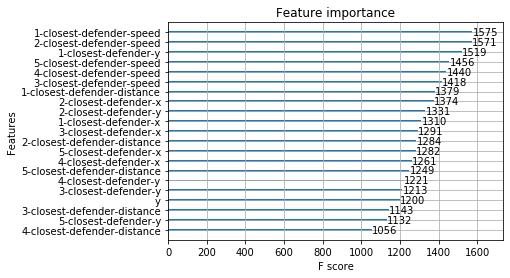

In [66]:
import xgboost as xgb
import joblib
bst = joblib.load("xyac_model.model")
xgb.plot_importance(bst)
scores = bst.get_score(importance_type='gain')
print(scores.keys())

In [70]:
vals = field_dfs.reset_index() 
important_columns = vals[['4-closest-defender-x', '1-closest-defender-speed', '2-closest-defender-speed', '4-closest-defender-speed', '1-closest-defender-distance', '3-closest-defender-x', 'y', '2-closest-defender-distance', '3-closest-defender-y', '5-closest-defender-x', '4-closest-defender-y', '1-closest-defender-y', '2-closest-defender-y', '5-closest-defender-distance', '5-closest-defender-speed', '1-closest-defender-x', '4-closest-defender-distance', '2-closest-defender-x', '5-closest-defender-y', '3-closest-defender-distance', '3-closest-defender-speed']]
display(important_columns)


4-closest-defender-x  1-closest-defender-speed  \
0                    43.792674                  0.829998   
1                    43.911318                  1.039998   
2                    44.085932                  1.389998   
3                    44.316517                  1.879998   
4                    44.603072                  2.509998   
5                    44.945598                  3.279998   
6                    45.344095                  4.189998   
7                    45.798561                  5.239998   
8                    46.308999                  6.429998   
9                    46.875406                  7.759998   
10                   47.497785                  9.000000   
11                   48.176133                  9.000000   
12                   48.894177                  9.000000   
13                   49.613797                  9.000000   
14                   50.333417                  9.000000   
15                   51.053037                  9.000000   
16                   51.772658                  9.000000   
17                   52.492278                  9.000000   
18                   53.211898                  9.000000   
19                   53.931519                  9.000000   
20                   54.651139                  9.000000   
21                   55.370759                  9.000000   
22                   56.090379                  9.000000   
23                   56.810000                  9.000000   
24                   57.529620                  9.000000   
25                   58.249240                  9.000000   
26                   58.968861                  9.000000   
27                   59.688481                  9.000000   
28                   60.408101                  9.000000   
29                   61.127721                  9.000000   
30                   61.847342                  9.000000   
31                   62.566962                  9.000000   
32                   63.286582                  9.000000   
33                   64.006203                  9.000000   
34                   64.725823                  9.000000   
35                   65.445443                  9.000000   
36                   66.165063                  9.000000   
37                   66.884684                  9.000000   
38                   67.604304                  9.000000   
39                   68.323924                  9.000000   
40                   43.791924                  0.830444   
41                   43.909340                  1.040444   
42                   44.082250                  1.390444   
43                   44.310652                  1.880444   
44                   44.594548                  2.510444   
45                   44.933936                  3.280444   
46                   45.328818                  4.190444   
47                   45.779192                  5.240444   
48                   46.285060                  6.430444   
49                   46.846420                  7.760444   
...                        ...                       ...   
12143950             79.427487                  9.000000   
12143951             80.164933                  9.000000   
12143952             80.902379                  9.000000   
12143953             81.639825                  9.000000   
12143954             82.377271                  9.000000   
12143955             83.114717                  9.000000   
12143956             83.852163                  9.000000   
12143957             84.589609                  9.000000   
12143958             85.327055                  9.000000   
12143959             86.064501                  9.000000   
12143960             56.835583                  1.440967   
12143961             58.134197                  1.650967   
12143962             58.812272                  2.000967   
12143963             59.543321                  2.490967   
12143964             60.284641                  3.